In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib import dates as mdates
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import argparse 
import sys
import os

#sys.path.insert(0, "Epidemiology_behavior_dynamics/run")
import config as cf

main_path = os.path.split(os.getcwd())[0]
config_path = main_path + '/config.csv'


config_data = pd.read_csv(config_path, sep=',', header=None, index_col=0)

networks_path = config_data.loc['networks_dir'][1]
results_path  = config_data.loc['results_dir'][1]
figures_path  = config_data.loc['figures_dir'][1]
awareness_path = config_data.loc['sigma_search_dir'][1]
infection_prob_path = config_data.loc['beta_search_dir'][1]
num_nodes     = 1000

sigma_search = pd.read_csv(os.path.join(main_path, awareness_path), dtype={'key':str, 'value':float})
beta_search  = pd.read_csv(os.path.join(main_path, infection_prob_path), dtype={'key':str, 'value':float})

time2Recover = (1/7)  # gamma

df = pd.concat([sigma_search, beta_search], axis=1)

list_df = []


In [2]:
path_to_ode_results = os.path.join(main_path, results_path, "ode_results")

func_beta = ["convex", "exponential", "linear", "concave", "s-shape"]

In [13]:
sigma_search = list(np.arange(0, 1,0.01)) + [1]
beta_search  = list(np.arange(0, 1,0.01)) + [1]

from tqdm import tqdm

df_results = []
for func in tqdm(func_beta):
    for idx_p, prob in enumerate(beta_search):
        for idx_s, sigma in enumerate(sigma_search):

            path_to_read_csv          = os.path.join(main_path, results_path, 'ode_results', func, 'ode_replicator_sigma_{:0.2f}_beta_{:0.2f}.csv'.format(sigma, prob))
            ode_df                    = pd.read_csv(path_to_read_csv)
            ode_df["sigma"]           = sigma
            ode_df["beta"]            = prob
            ode_df["type_response"]   = func

            df_results.append(ode_df)


100%|██████████| 5/5 [02:43<00:00, 32.66s/it]


In [19]:

df_all_results       = pd.concat(df_results)
df_all_results["R0"] = df_all_results["beta"]*7
df_all_results


,Unnamed: 0,time,sigma,beta,S,I,C,D,type_response,R0
0,0,0.000000,0.0,0.0,0.999800,0.000200,0.500000,0.500000,convex,0.0
1,1,0.501672,0.0,0.0,0.999814,0.000186,0.479109,0.520891,convex,0.0
2,2,1.003344,0.0,0.0,0.999827,0.000173,0.458291,0.541709,convex,0.0
3,3,1.505017,0.0,0.0,0.999839,0.000161,0.437618,0.562382,convex,0.0
4,4,2.006689,0.0,0.0,0.999850,0.000150,0.417159,0.582841,convex,0.0
...,...,...,...,...,...,...,...,...,...,...
295,295,147.993311,1.0,1.0,0.386342,0.613658,0.999324,0.000676,s-shape,7.0
296,296,148.494983,1.0,1.0,0.386379,0.613621,0.999337,0.000663,s-shape,7.0
297,297,148.996656,1.0,1.0,0.386416,0.613584,0.999349,0.000651,s-shape,7.0
298,298,149.498328,1.0,1.0,0.386452,0.613548,0.999362,0.000638,s-shape,7.0


In [20]:
def return_pivoted_df(df_to_pivot, param, var='I'):
    
    df_heat_map = df_to_pivot.copy()
    df_heat_map = df_heat_map.pivot(param, 'sigma', var)
    df_heat_map = df_heat_map.iloc[::-1]

    return df_heat_map

In [22]:
func_beta   = ["convex", "exponential", "linear", "concave", "s-shape"]
df_response = df_all_results.copy()

fig, ax = plt.subplots(2, 5, figsize=(20.5, 7.2), sharex=True, sharey=True)
for idx_t, ttype in enumerate(func_beta):
    df_response_plt = df_response.copy()
    df_response_plt = df_response_plt[df_response_plt.type_response==ttype]
    # df_response_plt = df_response_plt.reset_index()
    df_response_lastweek = df_response_plt.query("time >= 142")
    # steady state
    df_response_lastweek = df_response_lastweek.groupby(['R0', 'sigma']).mean()[['S', 'I', 'C','D']].reset_index()

    heatmap_epid = return_pivoted_df(df_response_lastweek, 'R0', 'I')
    heatmap_game = return_pivoted_df(df_response_lastweek, 'R0', 'C')

    sns.heatmap(ax = ax[0,idx_t], data=heatmap_epid, cmap='gist_heat_r',  cbar=True, vmin=0.0, vmax=1.0)
    sns.heatmap(ax = ax[1,idx_t], data=heatmap_game, cmap='RdYlGn',  cbar=True, vmin=0.0, vmax=1.0)

    ax[0,idx_t].set_title(f"{func_beta[idx_t].capitalize()}", fontsize=15)

    ax[0,0].set_ylabel(r'$R_{0}$', fontsize=15)
    ax[1,0].set_ylabel(r'$R_{0}$', fontsize=15)

    
    xticks = heatmap_epid.columns
    keptxticksidx = np.linspace(0,len(xticks),6)
    xtickslabels = list(xticks[ np.maximum(keptxticksidx.astype(int)-1,0) ])
    xtickslabels = ['{:.1f}'.format(l) for l in xtickslabels]


    yticks = heatmap_epid.index
    keptyticksidx = np.linspace(0,len(yticks),6)
    ytickslabels = list(yticks[ np.maximum(keptyticksidx.astype(int)-1,0) ])
    ytickslabels = ['{:.1f}'.format(l) for l in ytickslabels]

    

    for idx, axi in enumerate(ax.flatten()):
        # axi.xaxis.set_major_locator(mdates.MonthLocator())
        # axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
        axi.set_xticks(keptxticksidx)
        axi.set_xticklabels(xtickslabels, fontsize=20, rotation=0)
        axi.set_yticks(keptyticksidx)
        axi.set_yticklabels(ytickslabels, fontsize=20)
        axi.tick_params( which='both', axis='both', labelsize=15)
        axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
        axi.spines['right'].set_visible(False)
        axi.spines['top'].set_visible(False)
        axi.set_xlabel(r'Awareness $\sigma$', fontsize=15)
    plt.tight_layout()


In [7]:
beta_f2    = [0.3, 0.6, 0.9]
ro_f2      = [2.1, 4.2, 6.3]
awareness_f2 = [0.5, 0.7, 1]
kind_l       = ["Low", "Medium", "Full"]
change_resp = {"linear": "Linear", "convex": "Convex", "concave": "Concave 1", "exponential": "Exponential", "s-shape": "Concave 2"}

from tqdm import tqdm

df_results = []
for func in tqdm(func_beta):
    for idx_p, prob in enumerate(beta_f2):
        for idx_s, sigma in enumerate(awareness_f2):

            path_to_read_csv          = os.path.join(main_path, results_path, 'ode_results', func, 'ode_replicator_sigma_{:0.2f}_beta_{:0.2f}.csv'.format(sigma, prob))
            ode_df                    = pd.read_csv(path_to_read_csv)
            ode_df["sigma"]           = sigma
            ode_df["beta"]            = prob
            ode_df["type_response"]   = change_resp[func]

            df_results.append(ode_df)

df_all_results       = pd.concat(df_results)
df_all_results["R0"] = df_all_results["beta"]*7
df_all_results

100%|██████████| 5/5 [00:00<00:00, 31.33it/s]


,Unnamed: 0,time,sigma,beta,S,I,C,D,type_response,R0
0,0,0.000000,0.5,0.3,0.999800,0.000200,0.500000,0.500000,Convex,2.1
1,1,0.501672,0.5,0.3,0.999798,0.000202,0.479113,0.520887,Convex,2.1
2,2,1.003344,0.5,0.3,0.999796,0.000204,0.458300,0.541700,Convex,2.1
3,3,1.505017,0.5,0.3,0.999794,0.000206,0.437630,0.562370,Convex,2.1
4,4,2.006689,0.5,0.3,0.999790,0.000210,0.417175,0.582825,Convex,2.1
...,...,...,...,...,...,...,...,...,...,...
295,295,147.993311,1.0,0.9,0.424318,0.575682,0.997691,0.002309,Concave 2,6.3
296,296,148.494983,1.0,0.9,0.424407,0.575593,0.997720,0.002280,Concave 2,6.3
297,297,148.996656,1.0,0.9,0.424496,0.575504,0.997748,0.002252,Concave 2,6.3
298,298,149.498328,1.0,0.9,0.424583,0.575417,0.997776,0.002224,Concave 2,6.3


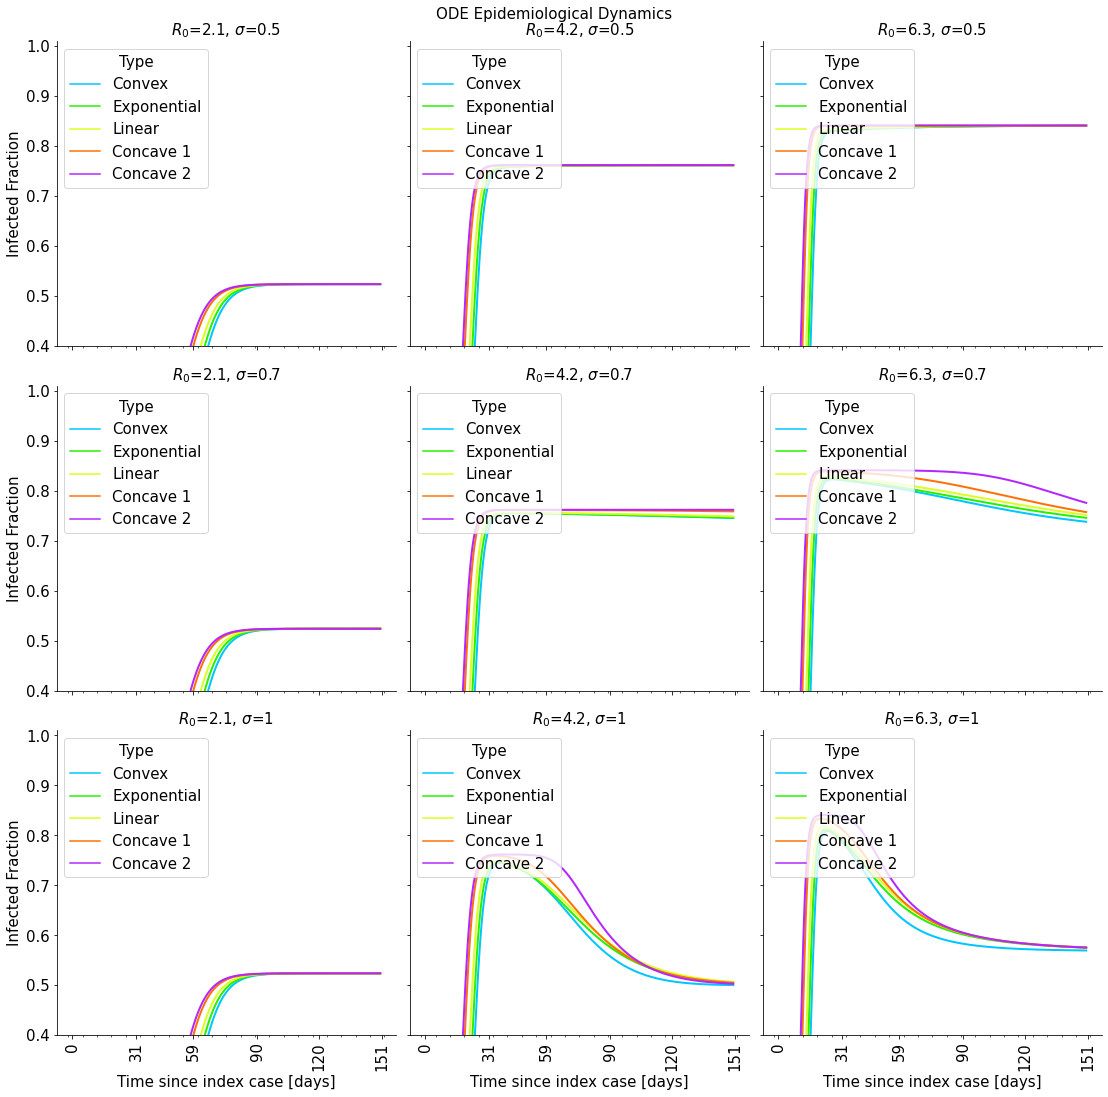

In [8]:

fig, ax = plt.subplots(3, 3, figsize=(15.5, 15.5), sharex=True, sharey=True)

import pylab 

cm = pylab.get_cmap('gist_ncar') 
for idx_b, beta in enumerate(beta_f2):
    for idx_s, sigma in enumerate(awareness_f2):

        df_response_plt = df_all_results[df_all_results.beta==beta].copy()
        df_response_plt = df_response_plt[df_response_plt.sigma==sigma].copy()
        #df_response_plt = df_response_plt[df_response_plt.function==ttype]
        # df_response_plt = df_response_plt[df_response_plt.type==type_s]

        sns.lineplot(ax=ax[idx_s, idx_b], data=df_response_plt.reset_index(), x="time", y="I", hue="type_response", palette="gist_ncar", lw=2)
        ax[idx_s, idx_b].set_ylim([0.4, 1.01])
        ax[idx_s, idx_b].set_title(r"$R_0$={}, $\sigma$={}".format(ro_f2[idx_b], sigma), fontsize=15)

for axi in ax.flatten():
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_xlabel("Time since index case [days]", fontsize=15)
    axi.set_ylabel("Infected Fraction", fontsize=15)
    axi.legend(fontsize=15, title="Type", title_fontsize=15, loc="upper left")

fig.suptitle(f"ODE Epidemiological Dynamics", fontsize=15) 
plt.tight_layout()
fig.savefig("ODE_infected_grid_r0sigma.png",  dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)


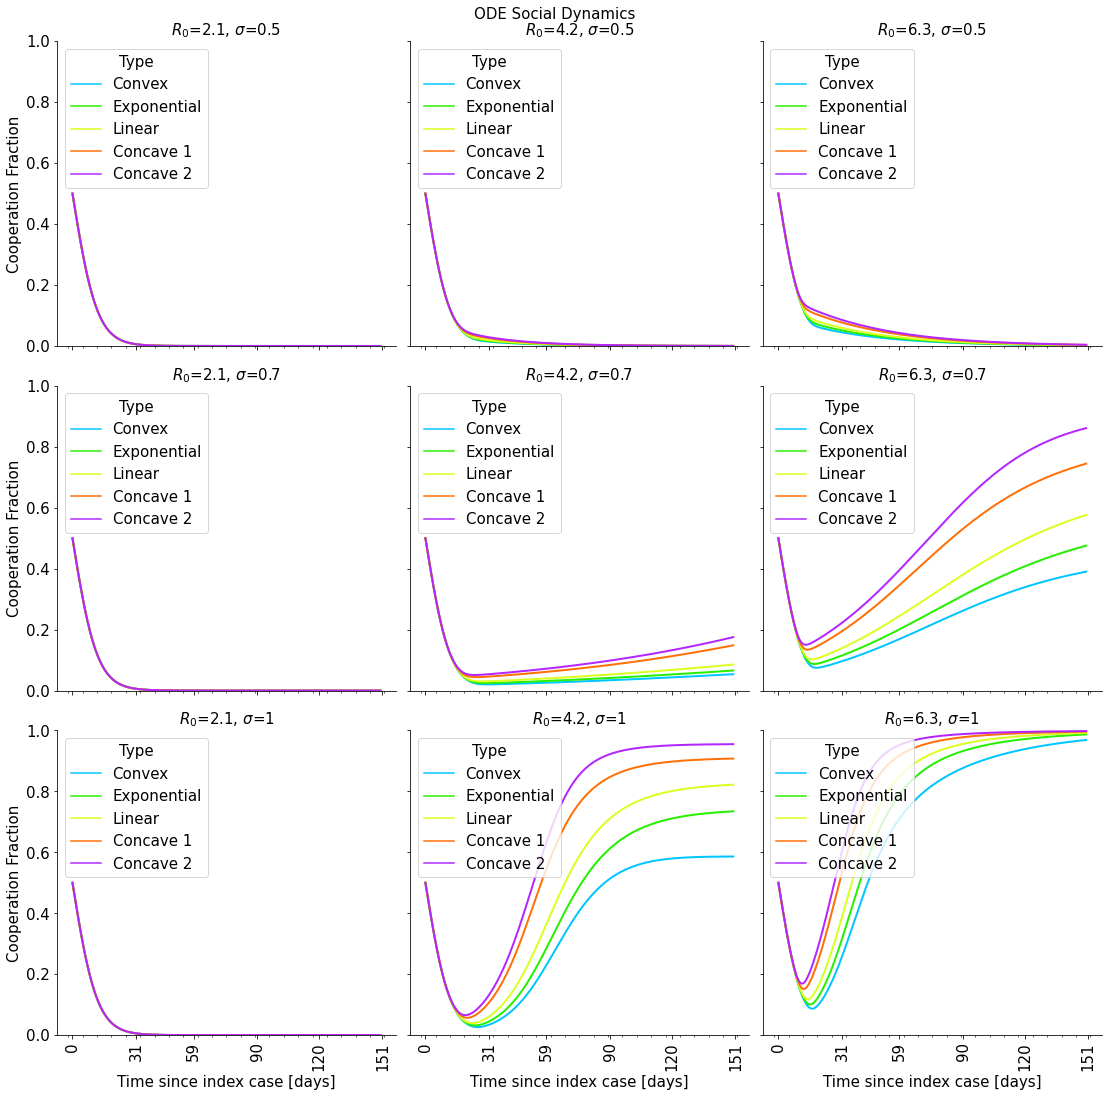

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(15.5, 15.5), sharex=True, sharey=True)
import pylab 

cm = pylab.get_cmap('gist_ncar') 
for idx_b, beta in enumerate(beta_f2):
    for idx_s, sigma in enumerate(awareness_f2):

        df_response_plt = df_all_results[df_all_results.beta==beta].copy()
        df_response_plt = df_response_plt[df_response_plt.sigma==sigma].copy()
        #df_response_plt = df_response_plt[df_response_plt.function==ttype]
        # df_response_plt = df_response_plt[df_response_plt.type==type_s]

        sns.lineplot(ax=ax[idx_s, idx_b], data=df_response_plt.reset_index(), x="time", y="C", hue="type_response", palette="gist_ncar", lw=2)
        ax[idx_s, idx_b].set_ylim([0, 1.0])
        ax[idx_s, idx_b].set_title(r"$R_0$={}, $\sigma$={}".format(ro_f2[idx_b], sigma), fontsize=15)

for axi in ax.flatten():
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_xlabel("Time since index case [days]", fontsize=15)
    axi.set_ylabel("Cooperation Fraction", fontsize=15)
    #axi.legend(fontsize=15, title=None, loc="upper left")
    axi.legend(fontsize=15, title="Type", title_fontsize=15, loc="upper left")

fig.suptitle(f"ODE Social Dynamics", fontsize=15) 

plt.tight_layout()
fig.savefig("ODE_cooperation_grid_r0sigma.png",  dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)